# Project: Predicting Boston Housing Prices
## Part of Udacity's Machine Learning Engineer Nanodegree
### Author: Mai Aye

## Introduction
In this project, I will evaluate the performance and predictive power of decision tree regressor and ridge regression models that have been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [21]:
# Importing libraries necessary for this project
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,make_scorer
from sklearn.tree import DecisionTreeRegressor

# Importing supplementary visualizations code visuals.py, provider by Udacity
import visuals as vs
import visualize as b
import build_model as k


# Pretty display for notebooks
%matplotlib inline

# Loading the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)

print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, I will make a cursory investigation about the Boston housing data and provide my observations. Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculating Statistics

In [10]:
#Calculating minimum price of the data
minimum_price = np.nanmin(data['MEDV'].values)

#Calculating maximum price of the data
maximum_price = np.max(data['MEDV'].values)

#Calculating mean price of the data
mean_price = np.mean(data['MEDV'].values)

#Calculating median price of the data
median_price = np.median(data['MEDV'].values)

#Calculating standard deviation of prices of the data
std_price = np.std(data['MEDV'].values)


print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

I expect that poor neighborhoods (high percentage of `'LSTAT'`) with low ratio of students to teachers in schools would decrease its median home value. The poorer the neighborhod, the lower the ratio of students to teachers would be, so I expect `'LSTAT'` and `'PTRATIO'` to be inversely correlated.  The vaerage number of rooms (`'RM'`) would depend on the neighorhood.  A poor neighborhood with the a higher number of average rooms, for example, would have a greater median home value compared to other poor neighbhoods with relatively smaller homes.    

----

## Developing a Model
In this second section of the project, I will develop the tools and techniques necessary for a model to make a prediction. 

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, I will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._


### 2 - Goodness of Fit

In [11]:
def performance_metric(y_true, y_predict):
    """Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    score = r2_score(y_true, y_predict)
    return score

In [13]:
# Calculating the performance of this model with dummy data
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


This model with dummy data successfully captures the variation in the target variable.  In other words, 92% of the target variable could be predicted or explained by input variables (X).

### Implementation: Shuffle and Split Data
My next implementation requires that I take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [14]:
# Shuffling and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices,train_size = 0.80,test_size = 0.20,random_state = 42)

#Success
print "Training and testing split was successful."

Training and testing split was successful.


### 3 - Training and Testing

Underfitting occurs when a model has high error in predicting data points in the training subset.  In other words, it fails to capture the underlying relationships in the data.  Overfitting occurs when the model is too complex that it predicts well on the training subset but not so much on the testing subset. The testing subset provides learning data in producing the optimal model, while the testing subset, acting as a independent data set, gives us an honest assessment of model performance.  Therefore, having separate training and testing subsets enables us to check overfitting and underfitting.

----

## Analyzing Model Performance
In this third section of the project, I'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, I'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing my model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

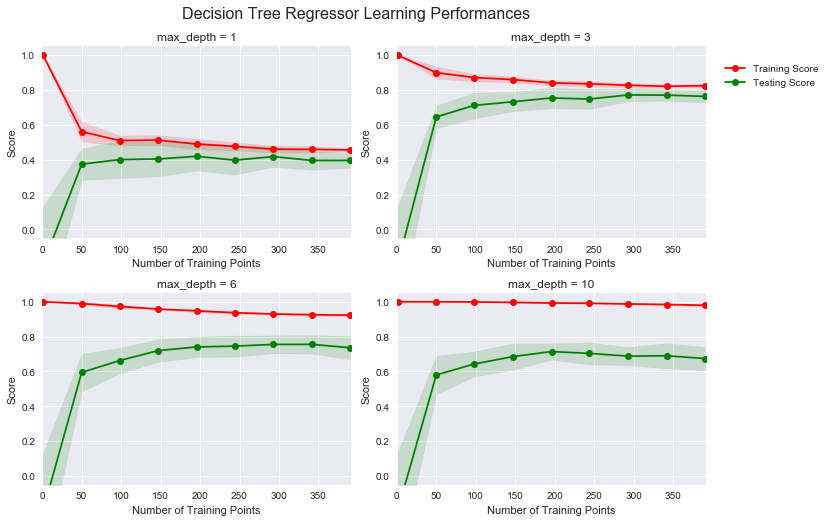

In [15]:
# Producing learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

###  4 - Learning the Data

Looking at graph for max_depth = 3 for the decision tree regressor model, the scores on the training curve decrease as more training points are added.  The scores on the testing curve increase but converge towards those on the training curve as more training points are added.  Having more training data points would not benefit the model, because the testing curves for all max_depths arrive at their optimal scores. 

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

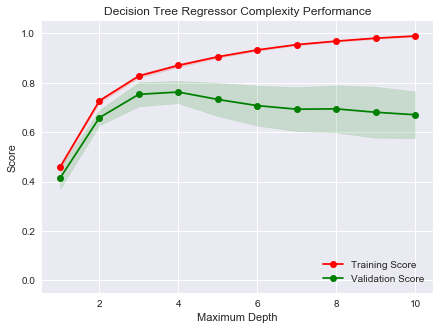

In [16]:
vs.ModelComplexity(X_train, y_train)

### 5 - Bias-Variance Tradeoff

When the model is trained with maximum depth of 1, it suffers from high bias.  Its low score of ~0.40 on both training and testing data sets indicate that it's not complex enough to capture subtleties in the data.  Maximum depth of 10, on the other hand, suffers from high variance.  Its high score of ~1.0 on the training set and its lower score of ~0.6 on the testing set  indicate that it's memorizing the subleties of training data but cannot generalize on the new data in the testing set. A model with maximum depth of 4 may provide an adequate tradeoff between high bias and high variance, because training and testing scores diverge significantly thereafter.    

### 6 - Best-Guess Optimal Model

The model with maximum depth of 4 generalizes the best to unseen data, because training and testing scores diverge significantly thereafter.  Testing score peaks at the model with maximum depth of 4 before it decreases at maximum depth of 5 and thereafter, while training and testing scores diverge significantly after maximum depth of 4.

-----

## Evaluating Model Performance
In this section of the project, I will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### 7 - Grid Search

The grid search method allows us to automatically tune parameters of my choice for a given model with a few lines of codes in Python GridSearchCV library.  'Grid' entails lists of values for the parameters we want tune that are fed into GridSearchCV pipepline to fit the model iteratively with a combination of parameters and finally return the right combination of parameters that produces the best-performing model.  For example, we could automatically tune the max_depth parameter of a decision tree regressor by putting in the list of max_depth values from 1 to 10 in the GridSearchCV pipeline: [1,2,3,4,5,6,7,8,9,10].  GridSearchCV will fit the model to the training data set using max_depths values from 1 to 10 and then return max_depth value that produces the best-performing decision tree regressor that has the best coefficient of determination (R^2).  We can use the best max_depth value of the decision tree model to make predictions on the testing data.

###  8 - Cross-Validation

Cross validation addresses the problem of overfitting by letting us train and test our model on different subsets of data.  More specifically, the K-fold cross validation technique entails splitting the data into training and testing sets into k folds without shuffling, where each fold acts as a testing or a validation set while the other remaining folds (k-1) make up the training set.  K-fold cross validation and grid search could work in tandem by alleviating overfitting and returning the best parameters for the model.  On one hand, there's a risk of overfitting on the testing set when tuning parameters manually, because parameters are tweaked, trained on the same training set, and the validated on the same testing set iteratively until the right combination of them produce the best-performing model.  To get around this, we can produce another set called the final test set: training on the training set, evaluate a combination of parameters on the testing set, and then apply the final combination of parameters  on the final testing set. But on the other hand, we have a very small data set, so subsetting the data into three sets reduces the sample data to train our model.  K-fold cross validation and grid search then address this problem, because a separate testing set during automatic parameter tuning in grid earch is no longer needed.  We could save the test set to evaluate the final combination of parameters.  In this approach, the training set is divided k smaller subsets .  A model is then trained on k-1 sets of the training data in grid search. The rest of remaining k subsets is then used as a test set to validate the combination of parameters being tuned.  Once grid search returns the best combination of parameters, we could evaluate them on the test set to get the model's final performance.       

### Implementation: Fitting a Model
In this section, I will train a model using the **decision tree algorithm**. To ensure that I'm producing an optimized model, I'll train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction.

In addition, I'll find my implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique described in **section 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set* or the test set. K-fold cross validation divides data into specified k number of folds, where every sample is in one fold or subet of the data.  Unlike K-fold, `ShuffleSplit()` produces training and testing sets iteratively by randomly sampling the entire data set with each iteration.  With each iteration, data points sampled in one iteration could be sampled again in another iteration.  `ShuffleSplit()` then is a more optimal option as data and cross validation time increase over time.

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. I can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

###  9 - Optimal Model

In [22]:
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, train_size=0.8, random_state=42)

    #Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=42)

    #Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': [1,2,3,4,5,6,7,8,9,10]}

    #Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric,greater_is_better=True)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor, param_grid=params, cv=cv_sets,scoring= scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [23]:
# Fitting the training data to the model using grid search
reg = fit_model(X_train, y_train)

#Producing the value for the best 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 3 for the optimal model.


The maximum depth for the optimal model is 3, close to my previous guest of 4.

In [24]:
#Making predictions and getting R^2
preds = reg.predict(X_test)
r2 = performance_metric(y_test, preds)
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(r2)

Model has a coefficient of determination, R^2, of 0.767.


###  10 - Predicting Selling Prices
A real estate agent in the Boston area is looking to use this model to help price homes owned by clients that they wish to sell. I have collected the following information from three of the clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

In [25]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $345,707.55
Predicted selling price for Client 2's home: $260,645.00
Predicted selling price for Client 3's home: $903,393.75


Because client 3 has the biggest house in a relatively affluent neighborhood with good schools, I would recommended the predicted selling price of 903,393.75 dollars, well above the median home price of 438,900.00 dollars.  Client 2 has the smallest house in a poorer neighorhood with not-so good schools, so I would recommend the predicted selling price of 260,645.00 dollars, well below the median home price.  However, client 1 seems to be in a middle class neighorhood compared to the other clients, so I would recommended the selling it at the median home price of 438,900.00 dollars, more than 100,000 dollars more from the predicted selling price.  

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

I run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.

In [26]:
model = vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $390,250.00
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $30,372.22


### 11 - Applicability of Decision Tree Regressor

It seems like this model is not sensitive.  The price range of ~ 30k is well below the standard deviation of 165,171.13.  However, its R^2 of ~0.72 indicates that the model is not highly robust.  Even though the prices of homes are adjusted to inflation, data collected in urban city like Boston might not be applicable to a rural city.  Unlike metropolitan areas, rural areas may have unique features like acres of lands.  Furthermore, seasonality is known to affect home selling prices.  Therefore, additional features like urban or rural location, seasonality, pools, proximity to amemnities like public transportation or waterfront areas, and square feet of plot area that that bring up home values are also needed to make the model more robust.  It may not be fair to judge an individual home based on the characteristics of the entire neighborhood,because a neighborhood could have subgroups or clusters of homes that are not necessarily similar.

## Ridge Regression

To further address the issue of overfitting and underfitting, I will implement ridge regression in this section.  Ridge regression balances the complexity and the fit of the model to produce an optimal model.  Balancing model’s complexity and fit is also known as l2 regularization.

Because I'll be using RSS (residual sum of squared errors) as an evaluation metric for model's performance, I first refit the decision tree regressor model with RSS as the metric to establish it as a baseline.

In [27]:
scaled_data = data
scaled_vals = MinMaxScaler().fit_transform(scaled_data)
scaled_data.loc[:,:] = scaled_vals

prices = scaled_data['MEDV']
features = scaled_data.drop('MEDV', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, prices,train_size = 0.80,test_size = 0.20,random_state = 42)

reg_rss = k.fit_model(X_train, y_train,'rss','regression_tree')
print "Parameter 'max_depth' is {} for the optimal model.".format(reg_rss.get_params()['max_depth'])
preds_rss = reg_rss.predict(X_test)
rss2 = k.rss(y_test, preds_rss)
print "Model has  RSS of {:.3f}.".format(rss2)

Parameter 'max_depth' is 3 for the optimal model.
Model has  RSS of 0.593.


I fit and predict on a ridge regression and tune the l2 or alpha parameter.  

Before fitting and predicting, I check for the distribution of the data.

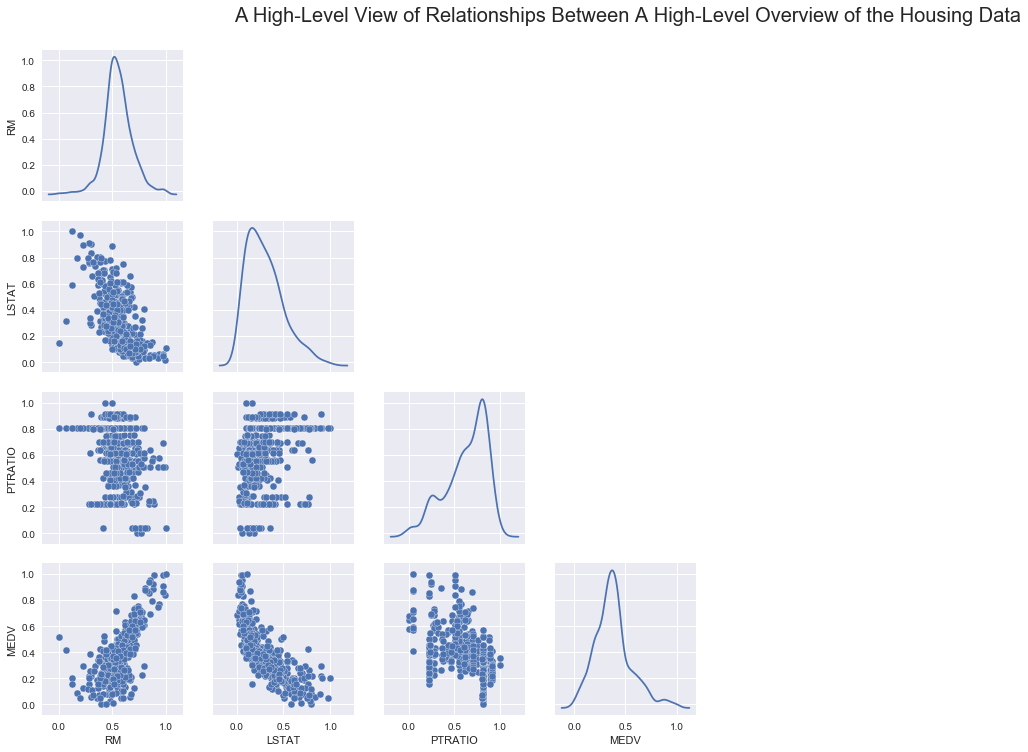

In [28]:
b.scttr_matrix(data,"distribution.png", "A High-Level Overview of the Housing Data")

The distributions of the variables look normal and don't have the tendencies to extremely skew either to the right or left so I fit and predict on the ridge regression by tuning the alpha values, the paraemter for l2 regularization.  

In [29]:
reg_ridge = k.fit_model(X_train, y_train,'rss','ridge')
print "Parameter 'alpha' is {} for the optimal model.".format(reg_ridge.get_params()['alpha'])
preds_ridge = reg_ridge.predict(X_test)

rss3 = k.rss(y_test, preds_ridge)
print "Model has  RSS of {:.3f}.".format(rss3)

Parameter 'alpha' is 0.1 for the optimal model.
Model has  RSS of 1.001.


Ridge regression's RSS of 1.001 is a lot higher as the decision tree regressor's RSS of ~ 0.59.  Hence, the decision tree regressor is a better model for this data set.  To enhance the performaces of both ridge regression and decision tree regressor models, more features that capture the subtletites driving home prices like seasonality, proximity to amenmities, and urban or rural locations may be needed.  Additional optimizations, such as gradient descent for ridge regression and the tuning of other paramters for the decision tree regressor, are also needed to improve both models.

## Sources

https://www.coursera.org/learn/ml-regression

http://scott.fortmann-roe.com/docs/BiasVariance.html

http://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/

https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/